In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Abstract
tbd

# Introduction
Thermocouples are widely used for temperature sensors in the automotive industry for measurement of exhaust gas temperature. One of the most suitable thermocouple type is type N. Typical sensor is made from probe, flexible cable and electronics. A pair of solid leads is inserted in the probe. The signal is conducted to the electronics by the flexible wires, which are again type N thermocouple. This is needed to create cold junction close to the electronics, where RTD sensor is used to measure the cold junction temperature. Type N thermocouples are delivered according standards, defining their accuracy. The sensor accuracy depends on the accuracy of the leads pair, flexible wire pair and the electronics. The following project demonstrates how the accuracy of leads and wires are combined using Monte Carlo algorithm. There are several complications that make simpler methods not applicable: the temperature of the weld between leads and wires is not known; the generated voltage is not linearly proportional to the temperature difference; leads and wires are made from different batches and their electromotive force is not equal.
![title](DTC.png)

In this study both leads and wires are delivered according ASTM E230 Type N thermo couple with accuracy class 1. The functions below define the accuracy.

# Goal definition
The goal of this study is to calcualte the accuracy of thermocouple sensor made from two TC pairs type N. 

Inputs:
1. TC pairs type N class 1 according ASTM E230
2. Assume the supplier of TC pairs is capable Ppk=1 (99.7% confidence;3σ) in the specification limits
3. Sensor tip temperatures of interest from 0 to 1100°C
4. Assume welds between both TC pairs are at the same temperature. This temeprature is in the range between 0°C and 260°C. It could be also assumed the weld temperature is equal to 0.3 mulltiplied by the temeprature of the tip.
5. The temeprature of the cold junction can in the range of 0°C to 150°C
6. Assume electronics adds no error.

Outputs:
1. Temperature accuracy of the sensor in typical conditions (cold junction at 20°C and weld at 0.3*T)
2. 4 temperature accuracy curves based on minimum and maximum temperatures of the cold juncion and welds.
3. All accuracy values should be delivered with 3σ confidence level
4. Acceptable variation from algoritm ouput should be within ±5% of mean value.

# ASTM E230 review and implementation
This section implements the required functions and tables from ASTM E230.

In [5]:
def leads_accuracy(Thot):
    """
    Thot is the temperature of the hot junction in °C
    The output is the absolute maximum acceptable deviation in °C
    """
    if Thot >= 0:
        return np.maximum(1.1, 0.004 * Thot)
    else:
        raise ValueError("ASTM E230 Type N class 1 does not cover sub zero temperatures")

def wires_accuracy(Thot):
    """
    Thot is the temperature of the hot junction in °C
    The output is the absolute maximum acceptable deviation in °C
    """
    if Thot >= 0:
        return np.maximum(1.1, 0.004 * Thot)
    else:
        raise ValueError("ASTM E230 Type N class 1 does not cover sub zero temperatures")


Let's plot the limits.

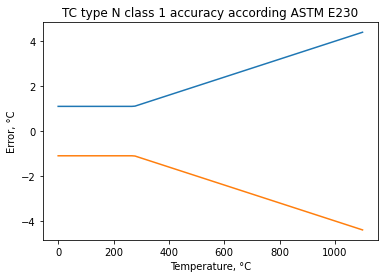

In [6]:
x_values = np.linspace(0, 1100, 100)
y_values = np.vectorize(leads_accuracy)(x_values)
plt.plot(x_values, y_values)
plt.plot(x_values, -y_values)

plt.title("TC type N class 1 accuracy according ASTM E230")
plt.xlabel("Temperature, °C")
plt.ylabel("Error, °C")
plt.show()

It is important to note that any curve within the limits defined above is acceptable. It is possible some TC batch to show curve strating from the lower psecification limit (LSL) goes up to upper specification limit (USL) and then goes down to LSL.

In order to make the transformations from the generated voltage to temperature and reverse, we need to define functions for the nominal transformation. These functions are polynoms, also defined in ASTM E230. The polynom coeficents depends on the voltage of interest, so several sets of polynoms are defined.

In [15]:
def temperature_typeN(emf):
    """
    acc ASTM E230, table 46 TYPE N Thermocouple
    E is the thermocouple emf in mV
    returns in °C
    """
    #the last is the free coeficent
    poly1 = np.poly1d([0.0073138868, 0.11582665, 0.77075166, 2.7754916, 5.8488586, 7.2060525, 5.2229312, 1.1010485, 38.436847,0])
    poly2 = np.poly1d([-0.0000000798156, 0.0000053928, -0.000117272, -0.00000212169, 0.0470205, -1.08267, 38.6896, 0]) 
    poly3 = np.poly1d([0.0000007767022, -0.0001274371, 0.009855391, -0.3915159, 33.00943, 19.72485]) 
    
    if -3.99 <= emf < 0:
        return poly1(emf)
    elif 0 <= emf < 20.613:
        return poly2(emf)
    elif 20.613 <= emf <= 47.513:
        return poly3(emf)
    else:
        raise ValueError(f"EMF value of {emf}mV is outside specified range!")

def emf_typeN(t):
    """
    acc ASTM E230, 
    t is the thermocouple hot junction temperature in °C
    returns in mv
    """
    #the last is the free coeficent
    poly1 = np.poly1d([-9.3419667835E-20, -7.608930791E-17, -2.2653438003E-14, -2.633357716E-12, -4.6412039759E-11, -9.3841111554E-08, 0.000010957484228, 0.026159105962, 0])
    poly2 = np.poly1d([-3.0682196151E-29, 2.0849229339E-25, -6.0863245607E-22, 9.9745338992E-19, -1.0063471519E-15, 6.4311819339E-13, -2.5261169794E-10, 4.3825627237E-08, 0.00001571014188, 0.025929394601, 0]) 
    
    if -270 <= t < 0:
        return poly1(t)
    elif 0 <= t <= 1300:
        return poly2(t)
    else:
        raise ValueError("Temperature outside specified range -270 to 1300°C")

def emf_typeN_derivative(t):
    """
    acc ASTM E230, 
    t is the thermocouple hot junction temperature in °C
    returns in mv
    """
    #the last is the free coeficent
    poly1 = np.poly1d([-9.3419667835E-20, -7.608930791E-17, -2.2653438003E-14, -2.633357716E-12, -4.6412039759E-11, -9.3841111554E-08, 0.000010957484228, 0.026159105962, 0])
    poly2 = np.poly1d([-3.0682196151E-29, 2.0849229339E-25, -6.0863245607E-22, 9.9745338992E-19, -1.0063471519E-15, 6.4311819339E-13, -2.5261169794E-10, 4.3825627237E-08, 0.00001571014188, 0.025929394601, 0]) 
    poly1 = np.polyder(poly1)
    poly2 = np.polyder(poly2)
    
    if -270 <= t < 0:
        return poly1(t)
    elif 0 <= t <= 1300:
        return poly2(t)
    else:
        raise ValueError("Temperature outside specified range -270 to 1300°C")
 

# the correctness of the polynominal coeficents is tested below.
# Keep in mind the forward and backward fucntion are approximations. Small diffrences are expected.
# print(temperature_typeN(emf_typeN(-200)))

# the code below defines fake function to test the effect of non-linearity of EMF vs temperature
# def temperature_typeN(x):
#     return x
# def emf_typeN(x):
#     return x

Let's plot the relation between electromotive force (EMF) and temperature:

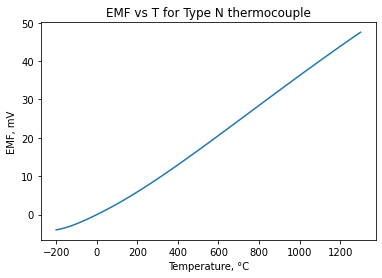

In [18]:
x_values = np.linspace(-200, 1300, 100)
y_values = np.vectorize(emf_typeN)(x_values)
plt.plot(x_values, y_values)
plt.title("EMF vs T for Type N thermocouple")
plt.xlabel("Temperature, °C")
plt.ylabel("EMF, mV")
plt.show()

The function is close to linear, but some curviture is easily seen.
Now let's see the first derivative. This gives indication for the sensitivity of the TC.

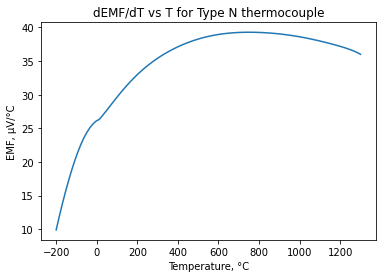

In [19]:
x_values = np.linspace(-200, 1300, 100)
y_values = np.vectorize(emf_typeN_derivative)(x_values)*1000
plt.plot(x_values, y_values)
plt.title("dEMF/dT vs T for Type N thermocouple")
plt.xlabel("Temperature, °C")
plt.ylabel("EMF, µV/°C")
plt.show()

# How does the sensor work
![title](TC_schema.png)
Steps to calculate the hot junction temperature:
1. ASIC measures the cold junction temperature (T2)
2. The ASIC measures the voltage across the cold junction (V2)
3. Calcualtes the expected V1 = f(T2)
4. Calcualtes V3 = V1 + V2
5. Calculates the hot junction temperature T3 = f(V3)

# Accuracy calculations
If the sensor was made from only one pair of leads, the accuracy is straightforward - defined in ASTM E230. However, the sensor consists of two pairs produced from diffrent material batches. The actual EMF characteristic may (will) differ for the leads and wires. It will be assumed the accuracy of delivered batches follows normal distribution with 3 sigma confidnce (Ppk=1). Such assumption is normal practise in the inidustry. Higher Ppk values could be requested, but are deemed as not feasable due to technology limitations and expected price increase.
Keep in mind that both ends of one TC pair add error. 
It will be assumed the temperature of the weld between the leads and wires is at the minimum of 0.3*T and 260°C. This assumption is realsitic, the upper limit of 260°C is defined by the resistance of the FKM seal. Also the accuracy limits are the same (±1.1°C) up to 275°C.
The temperature of the cold junction will be assumed 25°C. This value is below 275°C and the added error will be ±1.1°C.


In [22]:
def error_monte_carlo(t, t_weld = None, t_cold_junction = None, number_of_combos = None):
    if t_weld is None:
        t_weld = np.minimum(0.3*t, 260)
    if t_cold_junction is None:
        t_cold_junction = 20
    if number_of_combos is None:
        number_of_combos = 10000
    errors = np.zeros(number_of_combos, dtype=float)
    for i in range(number_of_combos):
        v_leads = emf_typeN(np.random.default_rng().normal(loc=t, scale=leads_accuracy(t) / 3)) - \
                  emf_typeN(np.random.default_rng().normal(loc=t_weld, scale=leads_accuracy(t_weld) / 3))
        v_wires = emf_typeN(np.random.default_rng().normal(loc=t_weld, scale=wires_accuracy(t_weld) / 3)) - \
                  emf_typeN(np.random.default_rng().normal(loc=t_cold_junction, scale=wires_accuracy(t_cold_junction) / 3))
        v_cold_junction = v_leads + v_wires
        # we are assuming the electronics adds no error; below is the calcualtion done by the electronics
        v_cold_junction_ref = emf_typeN(t_cold_junction)    
        t_calculated = temperature_typeN(v_cold_junction + v_cold_junction_ref)
        errors[i] = t_calculated - t
    return errors

def range_of_error_monte_carlo(t, t_weld = None, t_cold_junction = None, number_of_combos = None):
    errors = error_monte_carlo(t, t_weld, t_cold_junction, number_of_combos)
    return np.mean(errors), np.std(errors)

Testing the function at 1000°C:

The expected error at 1000°C is within 0.00±4.28°C with 3σ confidence.


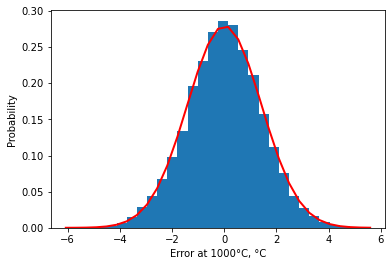

In [23]:
errors = error_monte_carlo(1000)
sigma = np.std(errors)
miu = np.mean(errors)
print(f"The expected error at 1000°C is within {miu:.2f}±{3*sigma:.2f}°C with 3σ confidence.")
count, bins, ignored = plt.hist(errors, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - miu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.xlabel("Error at 1000°C, °C")
plt.ylabel("Probability")
plt.show()

Results are as expected.

### How many combinations do we need?
More combinations will give more accuracte calcaultions, but infinity is not an option. We first have to set a target for calcualtion accuracy. Stepping on AIAG standards for measurment accuracy, the results of indepenedant measurments should not differ by more than 5%. At each propsoed number of combinations we will run 10 independant runs and check the variation.

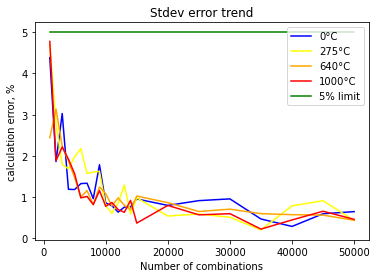

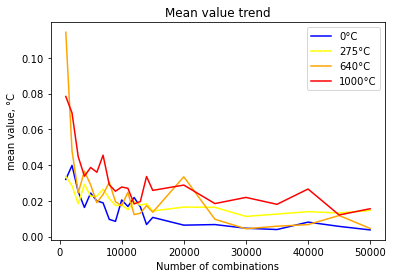

In [26]:
def measurment_accuracy_mc():
    temperatures = [0, 275, 640, 1000] # temperatures for which the stability of the implementation will be checked
    cmap = ["blue", "yellow", "orange", "red"]
    plot_mean = dict()
    plot_std = dict()
    x = list(range(1000, 15001, 1000))
    x.extend(list(range(20000, 50001, 5000))) #number of combinations to analyze
    for t in temperatures:
        plot_mean[t] = []
        plot_std[t] = [] 
        data_pool = error_monte_carlo(t, number_of_combos = 2*np.max(x)) # it is imperative the data pool to be larger than the number of values we pick
        for n_combos in x:
            run_means_results = []
            run_std_results = []
            for run in range(0, 10):
                data_sub_set = np.random.choice(data_pool, size=n_combos) 
                mean = np.mean(data_sub_set)
                stdev = np.std(data_sub_set)
                run_means_results.append(np.abs(mean))
                run_std_results.append(stdev)
            mean_of_std = np.mean(run_std_results)
            std_error = np.maximum(100 * (np.max(run_std_results) - mean_of_std) / mean_of_std,
                                   100 * (mean_of_std - np.max(run_std_results)) / mean_of_std
                                   )
            plot_mean[t].append(np.max(run_means_results))
            plot_std[t].append(std_error)

    for i, t in enumerate(temperatures):
        plt.plot(x, plot_std[t], color = cmap[i], label=f"{t}°C")
    plt.plot([np.min(x), np.max(x)], [5, 5], color = "green", label="5% limit")
    plt.title("Stdev error trend")
    plt.xlabel("Number of combinations")
    plt.ylabel("calculation error, %")
    plt.legend(loc="upper right")
    plt.show()
    
    for i, t in enumerate(temperatures):
        plt.plot(x, plot_mean[t], color = cmap[i], label=f"{t}°C")
    plt.title("Mean value trend")
    plt.xlabel("Number of combinations")
    plt.ylabel("mean value, °C")
    plt.legend()
    plt.show()
    
    
measurment_accuracy_mc()

The data shows 10000 combinations cover the 5% requirment with enough confidence. The mean nvalue is close to the true value ot 0.

# Calculating the error
Below the expected error range is calcualted with 3σ confidence.

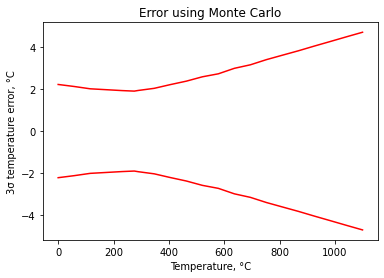

In [27]:
def error_in_temperature_range(t_min, t_max, function):
    x = np.linspace(t_min, t_max, 20)
    x = np.sort(np.append(x, [1.1/0.004])) #adding a key point from lead accuracy specificaion
    y, y_dev = np.vectorize(function)(x)
    plt.plot(x, 3*y_dev, color = "red")
    plt.plot(x, -3*y_dev, color = "red")
    plt.title("Error using Monte Carlo")
    plt.xlabel("Temperature, °C")
    plt.ylabel("3σ temperature error, °C")
    plt.show()
error_in_temperature_range(0, 1100, range_of_error_monte_carlo)

At first glance it is a little strange why the error is larger at 0°C than at 200°C. The accuracy of both leads and wires is constant at ±1.1°C up to 275°C. However, the function EMF(t) is not linear; the slope of the EMF(t) function changes significantly between 0°C and 200°C. It was checked that with fake linear function EMF(t), the error remains constant at low temperatures.

One could propose that in this calcualtion we are approximately summing 4 normal distributions. The net result could be calculated by the SRSS rule.

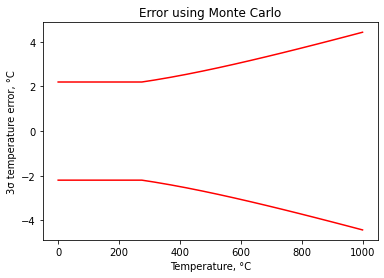

In [28]:
def range_of_error_srss(t, t_cold_junction = 20):
    trh = np.minimum(0.3*t, 260)
    net_stdev = np.sqrt((leads_accuracy(t) / 3)**2 + \
                        (leads_accuracy(trh) / 3)**2 + \
                        (wires_accuracy(trh) / 3)**2 + \
                        (wires_accuracy(t_cold_junction) / 3)**2)
    return 0, net_stdev

error_in_temperature_range(0, 1000, range_of_error_srss)

We are going to plot Monte Carlo and SRSS on the same graph for better comaprison.

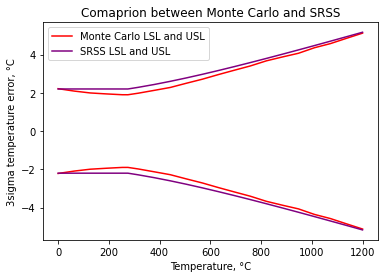

In [29]:
def plot_monte_carlo_and_srss(t_min, t_max):
    x = np.linspace(t_min, t_max, 20)
    x = np.sort(np.append(x, [1.1/0.004])) #adding a key point from lead accuracy specificaion
    
    _, y_dev_srss = np.vectorize(range_of_error_srss)(x)
    _, y_dev_mc = np.vectorize(range_of_error_monte_carlo)(x)
    
    plt.plot(x, 3*y_dev_mc, color = "red", label="Monte Carlo LSL and USL")
#     plt.plot(x, y_mc, color = "black", label="Monte Carlo mean")
    plt.plot(x, -3*y_dev_mc, color = "red")
    
    plt.plot(x, 3* y_dev_srss, color = "purple", label="SRSS LSL and USL")
    plt.plot(x, -3*y_dev_srss, color = "purple")
    
    plt.legend()
    plt.xlabel("Temperature, °C")
    plt.ylabel("3sigma temperature error, °C")
    plt.title("Comaprion between Monte Carlo and SRSS")
    plt.show()
plot_monte_carlo_and_srss(0, 1200)

The SRSS method is quite close to the Monte Carlo results, but little on the safe side. It is confirmed the diffrence is again due to the non liear function EMF(t). See the picture below, when EMF(t) = t:
![title](MC_vs_SRSS_when_linear_EMF.png)

# Conclusion
The accuracy of a TC can be calculated with the demonstrated Monte Carlo algoritm. SRSS is a quick and dirty alternative that can be used for rough estimation only, it tends to be on the safe side for most of the temperatures. Worst case (sum of all errors) would indicate much bigger error, but the probability to have 4 factors at border is very small.
With minor modifications of the code above, one could adjust the calcualtions to evaluate similar scenarios. 


# Discussion
### Comparion between Monte Carlo, SRSS and worst case.
### What if the EMF(T) model was linear?

# References

In [58]:
import pandas as pd
pt_data = pd.read_excel("2021-04-20 Tanaka lot data.xlsx")
pt_data

,Date,Date US,Lot No.,"el produced, %","UTS as produced, Mpa","UTS annealed, Mpa","UTS after SRT, Mpa","UTS change by SRT, Mpa",Hardness (HV),"el1, %","el2, %","el3, %","el4, %","el5, %","el6, %","el7, %","el mean, %","el stdev, %","el range, %",comment
0,29.03.2021,2021-03-29,L3000277207876,7.641,559.16,497.19,494.13,-3.06,174.4,6.40,6.18,7.18,7.62,6.19,6.86,7.55,6.854286,0.570560,1.44,NaN
1,25.02.2021,2021-02-25,L3000275195692,7.216,578.24,516.13,516.87,0.74,177.6,6.35,7.02,7.08,7.22,7.22,7.10,7.14,7.018571,0.281142,0.87,NaN
2,26.01.2021,2021-01-26,L3000273231819,7.181,578.33,513.49,514.27,0.78,181.1,8.02,6.28,6.68,7.64,7.60,7.50,7.54,7.322857,0.566032,1.74,NaN
3,15.12.2020,2020-12-15,L3000271059246,7.594,531.93,465.17,441.53,-23.64,165.0,4.88,5.60,6.58,6.86,6.66,5.68,4.84,5.871429,0.779953,2.02,some drop in UST after SRT
4,24.11.2020,2020-11-24,L3000269740602,7.661,539.23,477.84,470.50,-7.34,168.9,5.50,6.91,7.78,7.11,5.83,5.67,6.59,6.484286,0.785836,2.28,NaN
5,23.10.2020,2020-10-23,L3000268082262,7.534,578.79,513.34,516.10,2.76,184.3,6.56,8.25,6.02,6.66,7.40,8.18,6.04,7.015714,0.870498,2.23,NaN
6,18.09.2020,2020-09-18,L3000266033394,7.017,569.67,504.69,508.77,4.08,180.9,5.92,5.94,6.76,7.46,5.54,6.34,5.34,6.185714,0.680396,2.12,NaN
7,04.08.2020,2020-08-04,L3000263854116,7.531,573.31,508.07,509.43,1.36,181.1,7.04,8.18,7.64,7.62,7.68,6.63,7.04,7.404286,0.484734,1.55,NaN
8,24.04.2020,2020-04-24,L3000259207696,7.313,563.97,502.86,506.23,3.37,174.0,7.66,8.52,8.20,6.68,6.86,8.86,7.84,7.802857,0.752248,2.18,NaN
9,21.04.2020,2020-04-21,L3000258918120,7.369,588.07,522.89,525.07,2.18,184.3,7.30,8.44,4.84,6.46,7.22,7.92,7.55,7.104286,1.085092,3.60,NaN


In [59]:
filtered_data = pt_data.iloc[:,:8].append(pt_data.iloc[:,16:])

filtered_data.corr()

,"el produced, %","UTS as produced, Mpa","UTS annealed, Mpa","UTS after SRT, Mpa","UTS change by SRT, Mpa","el mean, %","el stdev, %","el range, %"
"el produced, %",1.000000,0.322943,0.448569,0.411541,0.068411,NaN,NaN,NaN
"UTS as produced, Mpa",0.322943,1.000000,0.835664,0.853721,0.393422,NaN,NaN,NaN
"UTS annealed, Mpa",0.448569,0.835664,1.000000,0.948393,0.247055,NaN,NaN,NaN
"UTS after SRT, Mpa",0.411541,0.853721,0.948393,1.000000,0.541575,NaN,NaN,NaN
"UTS change by SRT, Mpa",0.068411,0.393422,0.247055,0.541575,1.000000,NaN,NaN,NaN
"el mean, %",NaN,NaN,NaN,NaN,NaN,1.000000,-0.297182,-0.247263
"el stdev, %",NaN,NaN,NaN,NaN,NaN,-0.297182,1.000000,0.953154
"el range, %",NaN,NaN,NaN,NaN,NaN,-0.247263,0.953154,1.000000
